In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

2025-05-19 15:20:40.539993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 15:20:40.552263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-19 15:20:40.555713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 15:20:40.564332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
GlobalAveragePooling2D = tf.keras.layers.GlobalAveragePooling2D
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

Sequential = tf.keras.models.Sequential

VGG16 = tf.keras.applications.vgg16.VGG16
preprocess_input = tf.keras.applications.vgg16.preprocess_input

ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

In [3]:
seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [7]:
!unzip -qq '../data/dogs-vs-cats.zip'

In [11]:
!unzip -qq '../data/dogs-vs-cats/train.zip'

In [4]:
train_df = pd.DataFrame({"file" : os.listdir("../data/dogs-vs-cats/train")})
train_df["label"] = train_df["file"].apply(lambda x : x.split(".")[0])

train_df.head()

,file,label
0,dog.6521.jpg,dog
1,cat.10580.jpg,cat
2,dog.6606.jpg,dog
3,dog.8055.jpg,dog
4,cat.7981.jpg,cat


In [5]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df,
                                        test_size=0.2,
                                        stratify=train_df["label"],
                                        random_state=13)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
FILES = "../data/dogs-vs-cats/"
batch_size = 16
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=FILES + "train",
    x_col="file",
    y_col="label",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=batch_size,
    seed=13
)

Found 20000 validated image filenames belonging to 2 classes.


In [8]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=FILES + "train",
    x_col="file",
    y_col="label",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=batch_size,
    seed=13,
    shuffle=False
)

Found 5000 validated image filenames belonging to 2 classes.


In [9]:
base_model = VGG16(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False
)

I0000 00:00:1747635660.814686   49629 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747635660.841101   49629 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747635660.841408   49629 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1747635660.842691   49629 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
for layers in base_model.layers:
    layers.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
def vgg16_pretrained():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)

    outputs = Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [13]:
tf.keras.backend.clear_session()

In [14]:
model = vgg16_pretrained()
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,772,582 (56.35 MB)

 Trainable params: 57,894 (226.15 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.2,
    patience = 5,
    min_lr = 0.0001
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 3
)

In [16]:
check_point = tf.keras.callbacks.ModelCheckpoint(
    monitor = "val_accuracy",
    filepath = "./vgg16_pretrained.weights.h5",
    save_best_only = True,
    save_weights_only = True
)

In [17]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 5,
    callbacks = [reduce_lr, early_stopping, check_point]
)

/home/kth/anaconda3/envs/dl_venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1747635683.711669   49958 service.cc:146] XLA service 0x74d4a000dac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747635683.711687   49958 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-05-19 15:21:23.743289: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-19 15:21:23.941743: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:08 55ms/step - accuracy: 0.6094 - loss: 2.8961 

I0000 00:00:1747635691.029211   49958 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 177s 135ms/step - accuracy: 0.9236 - loss: 0.2844 - val_accuracy: 0.9776 - val_loss: 0.0621 - learning_rate: 0.0010
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 166s 133ms/step - accuracy: 0.9735 - loss: 0.0770 - val_accuracy: 0.9824 - val_loss: 0.0518 - learning_rate: 0.0010
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 132ms/step - accuracy: 0.9774 - loss: 0.0624 - val_accuracy: 0.9838 - val_loss: 0.0455 - learning_rate: 0.0010
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 164s 131ms/step - accuracy: 0.9802 - loss: 0.0551 - val_accuracy: 0.9850 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 165s 132ms/step - accuracy: 0.9810 - loss: 0.0503 - val_accuracy: 0.9860 - val_loss: 0.0436 - learning_rate: 0.0010


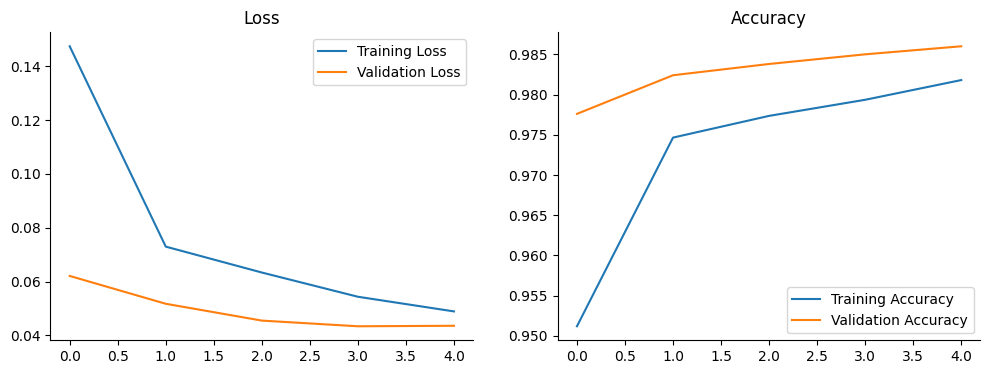

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(x=range(len(history.history["loss"])),
             y=history.history["loss"], ax=axes[0],
             label="Training Loss")
sns.lineplot(x=range(len(history.history["loss"])),
             y=history.history["val_loss"], ax=axes[0],
             label="Validation Loss")

sns.lineplot(x=range(len(history.history["accuracy"])),
             y=history.history["accuracy"], ax=axes[1],
             label="Training Accuracy")
sns.lineplot(x=range(len(history.history["accuracy"])),
             y=history.history["val_accuracy"], ax=axes[1],
             label="Validation Accuracy")
axes[0].set_title("Loss")
axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [19]:
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"{val_accuracy:.4f}")
print(f"{val_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9855 - loss: 0.0542
0.9860
0.0436


In [20]:
val_pred = model.predict(val_generator)

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step


In [21]:
val_data.loc[:, "val_pred"] = np.argmax(val_pred, axis=1)
labels = dict((v, k) for k, v in val_generator.class_indices.items())
val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)

val_data.head(10)

/tmp/ipykernel_49629/349242900.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['cat' 'dog' 'cat' ... 'cat' 'dog' 'dog']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)


,file,label,val_pred
7668,cat.3443.jpg,cat,cat
19055,dog.10035.jpg,dog,dog
15566,cat.4876.jpg,cat,cat
12028,dog.12025.jpg,dog,dog
15850,dog.10979.jpg,dog,dog
6776,cat.10847.jpg,cat,cat
17314,dog.757.jpg,dog,dog
911,dog.5612.jpg,dog,dog
17888,cat.5828.jpg,cat,cat
3691,cat.11990.jpg,cat,cat


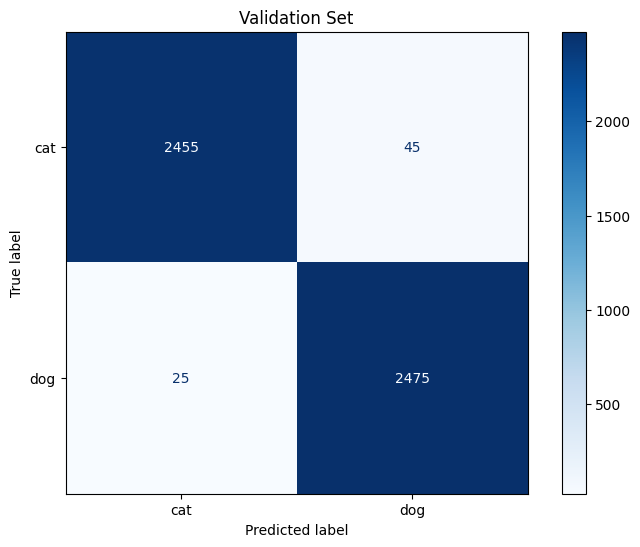

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(9, 6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["cat", "dog"])
disp.plot(cmap=plt.cm.Blues, ax=ax)

ax.set_title("Validation Set")
plt.show()